In [184]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st

In [118]:
level = pd.read_csv('partially_cleaned_salt_lake_historical_data.csv')

# Only save the month from the listed date
for i in range(len(level)):
    level.datetime[i] = level.datetime[i][:7]
    
# Average over all months
monthly = level.groupby('datetime').mean()

# Make a 'month' column
monthly['month'] = np.array([int(monthly.index[i][-2:]) for i in range(len(monthly))])

# Take one finite difference
monthly['delta'] = np.concatenate(([0], np.diff(monthly.depth)))

# Take moving average 
ma = np.convolve(monthly.delta.values, np.ones(12)/12, mode='valid')
monthly['MA'] = np.concatenate((np.nan*np.zeros(11), ma))

# Cut off first 676 elements (so we have no nans). We could cut off only first 671, but that leaves a non-whole number of years
monthly = monthly[676:]

# Find seasonal component
seasonal = monthly.groupby('month')['T'].mean()
monthly['S'] = np.tile(np.roll(seasonal.values, shift=-1), 117)

# Find remainder
monthly['R'] = monthly.delta - monthly.MA - monthly.S

# Year array
year = (np.arange(len(monthly)) + 1)/12 + 1904

<ipython-input-118-ab8d086836c2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level.datetime[i] = level.datetime[i][:7]


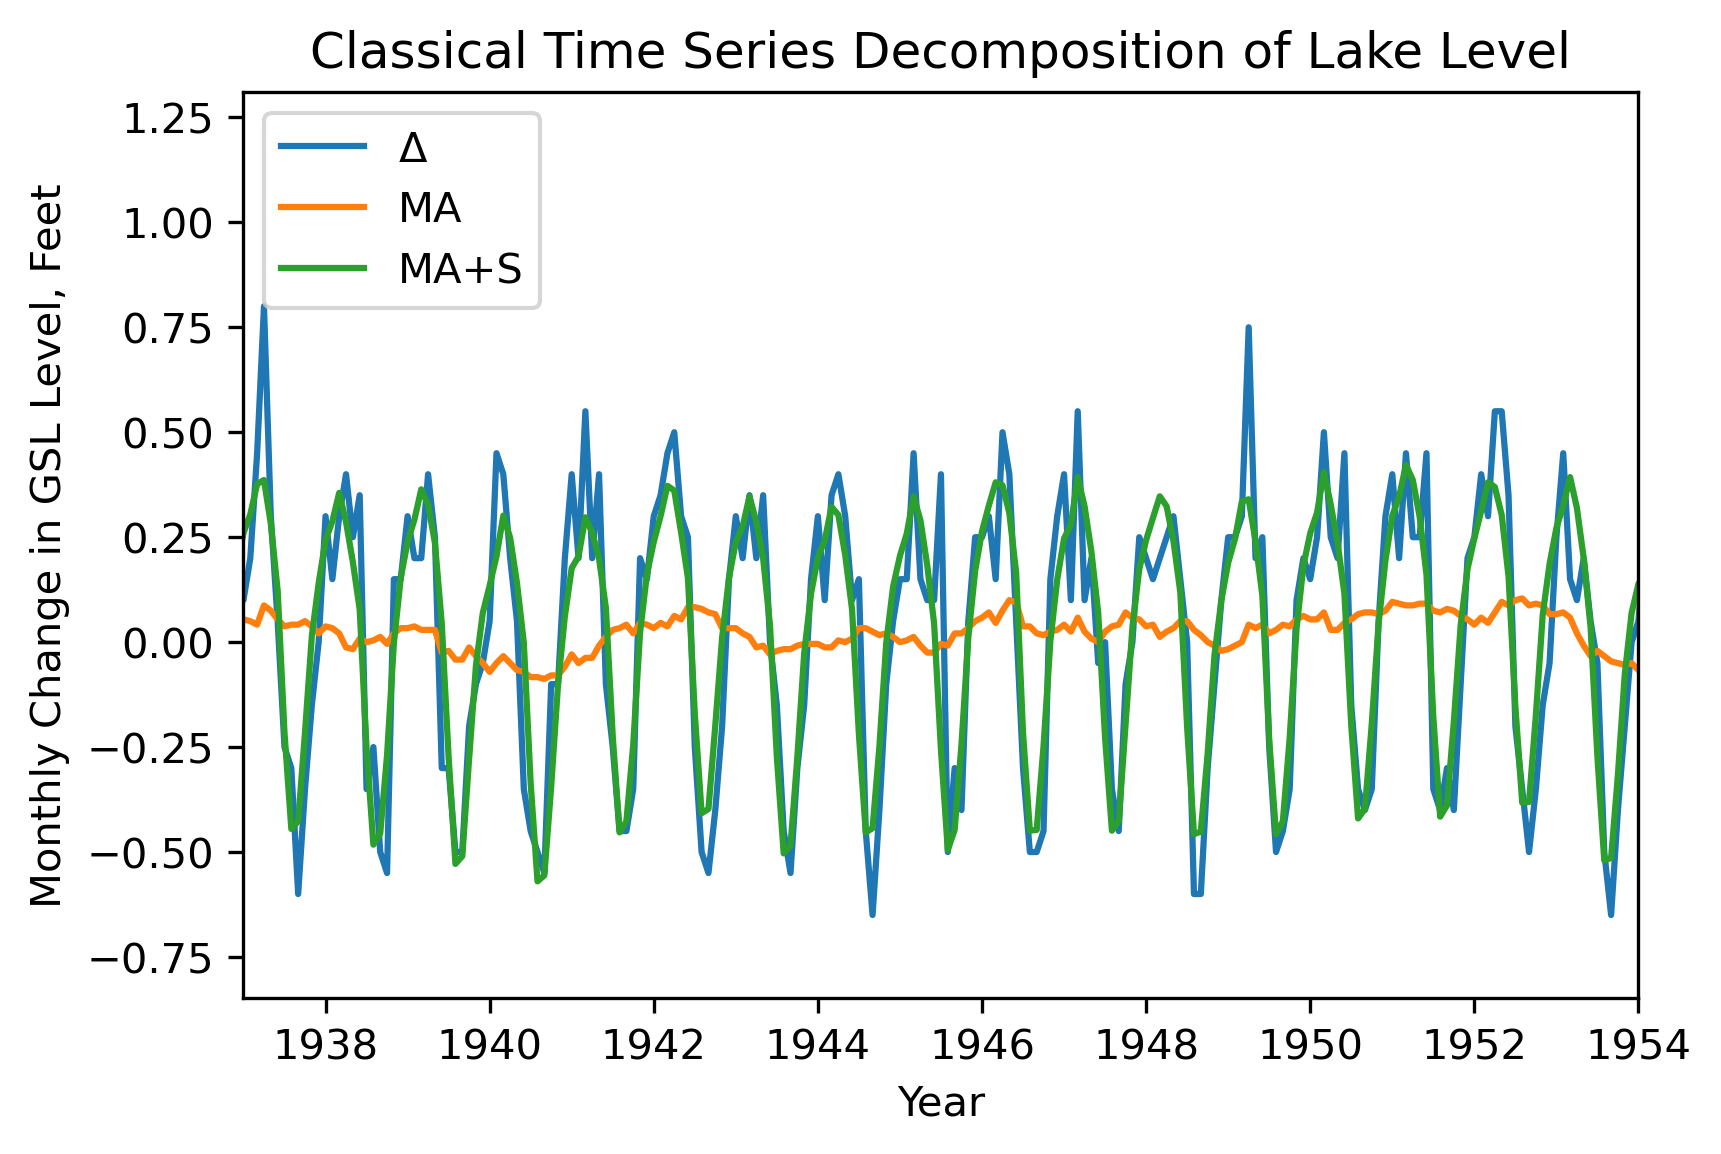

In [163]:
fig = plt.figure(figsize=(6,4), dpi=300)

plt.plot(year,  monthly['delta'], label=r'$\Delta$')
plt.plot(year, monthly.MA, label='MA')
plt.plot(year, monthly.S + monthly.MA, label='MA+S')
plt.xlim(1937, 1954)
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Monthly Change in GSL Level, Feet')
plt.title('Classical Time Series Decomposition of Lake Level')
plt.show()

<AxesSubplot:>

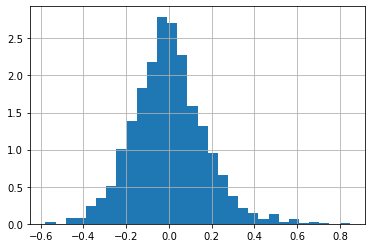

In [183]:
monthly.R.hist(bins=30, density=True)
plt.plot